<a href="https://colab.research.google.com/github/Yoavvvvvv/Computer-vision/blob/main/Image%20Classifiacation%20with%20ResNet%20transfer%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

from keras.layers import Dense, Activation, Flatten



from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import glob

In [79]:
image_size = [50,50]
epochs = 16
bactch_size = 128

In [53]:
train_path = '/content/drive/MyDrive/Colab Notebooks/DATASETS/fruits-360-original-size/fruits-360-original-size/Training'
test_path = '/content/drive/MyDrive/Colab Notebooks/DATASETS/fruits-360-original-size/fruits-360-original-size/Test'
val_path = '/content/drive/MyDrive/Colab Notebooks/DATASETS/fruits-360-original-size/fruits-360-original-size/Validation'

In [58]:
train_images = glob.glob(train_path + '/*/*.jp*g')
test_images = glob.glob(test_path + '/*/*.jp*g')
val_images = glob.glob(val_path + '/*/*.jp*g')

In [40]:
train_labels_folders = glob.glob( '/*')

In [41]:
def plot_image(image):
  plt.imshow(image);
  plt.axis('off');
  plt.show()

In [42]:
def resize_image(image):
  image = tf.keras.utils.load_img(np.random.choice(train_images))
  resized_image = tf.image.resize(image,[224,224])
  resized_image = np.array(resized_image,np.int32)
  return resized_image

In [80]:
resize_image(image).shape

(224, 224, 3)

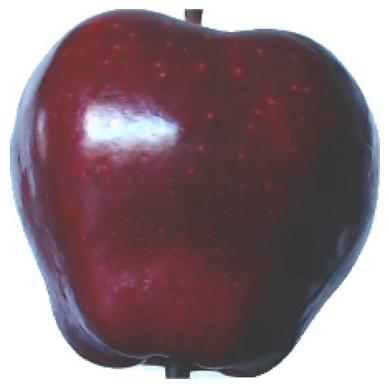

In [81]:
plt.imshow(resize_image(image))
plt.axis('off')
plt.show()

In [83]:
resnet50 = ResNet50(input_shape = image_size +[3], include_top=False, weights='imagenet')

In [84]:
#freezing resnet layer so only final leyer will be trained
for layer in resnet50.layers:
  layer.trainable = False

x = Flatten()(resnet50.output)
prediction = Dense(len(train_labels_folders), activation='softmax')(x)

In [85]:
model = Model(inputs = resnet50.input, outputs = prediction)

In [86]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 56, 56, 3)            0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 25, 25, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 25, 25, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [87]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])

In [88]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True,
    preprocessing_function=preprocess_input
)

val_gen  = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [89]:
test_gen = val_gen.flow_from_directory(val_path, target_size=image_size)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 3114 images belonging to 24 classes.
{'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}


min:  -120.68 max:  151.061


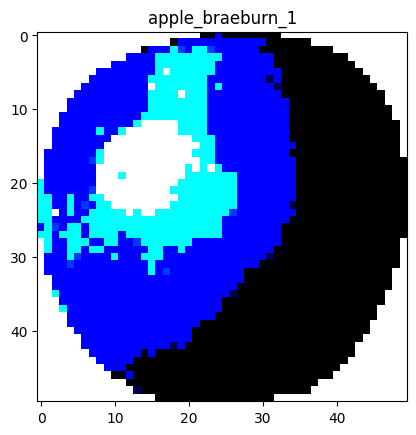

In [90]:
for x,y in test_gen:
  print("min: ", x[0].min(), "max: ", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [91]:
train_gen = train_gen.flow_from_directory(train_path, target_size=image_size, batch_size=bactch_size, class_mode = 'sparse')
val_gen = val_gen.flow_from_directory(val_path, target_size=image_size, batch_size=bactch_size, class_mode = 'sparse')

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [92]:
type(train_gen)

keras.src.preprocessing.image.DirectoryIterator

In [93]:
steps_per_epoch_half = train_gen.samples // (2 * train_gen.batch_size)
steps_per_epoch_quarter = train_gen.samples // (4 * train_gen.batch_size)

In [94]:
from keras.callbacks import LearningRateScheduler
import math

In [95]:
def lr_schedule(epoch):
    initial_lr = 0.1  # Initial learning rate
    decay = 0.1  # Decay rate
    lr = initial_lr * math.pow(decay, math.floor((1+epoch)/10))  # Learning rate decay
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [96]:
history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = epochs,
    steps_per_epoch = 1,
    validation_steps = len(val_images)//bactch_size
    #callbacks=[lr_scheduler]
    )

Epoch 1/16
1/1 [==============================] - 95s 95s/step - loss: 10.4448 - accuracy: 0.0312 - val_loss: 6.4513 - val_accuracy: 0.1159
Epoch 2/16
1/1 [==============================] - 86s 86s/step - loss: 6.2455 - accuracy: 0.0938 - val_loss: 4.7648 - val_accuracy: 0.2126
Epoch 3/16
1/1 [==============================] - 85s 85s/step - loss: 4.1874 - accuracy: 0.2969 - val_loss: 4.5176 - val_accuracy: 0.2979
Epoch 4/16
1/1 [==============================] - 87s 87s/step - loss: 3.5357 - accuracy: 0.3281 - val_loss: 3.4269 - val_accuracy: 0.4808
Epoch 5/16
1/1 [==============================] - 87s 87s/step - loss: 2.6386 - accuracy: 0.5234 - val_loss: 3.4326 - val_accuracy: 0.4977
Epoch 6/16
1/1 [==============================] - 59s 59s/step - loss: 2.8848 - accuracy: 0.4844 - val_loss: 2.9833 - val_accuracy: 0.5706
Epoch 7/16
1/1 [==============================] - 85s 85s/step - loss: 2.8546 - accuracy: 0.5747 - val_loss: 2.3867 - val_accuracy: 0.6061
Epoch 8/16
1/1 [==========

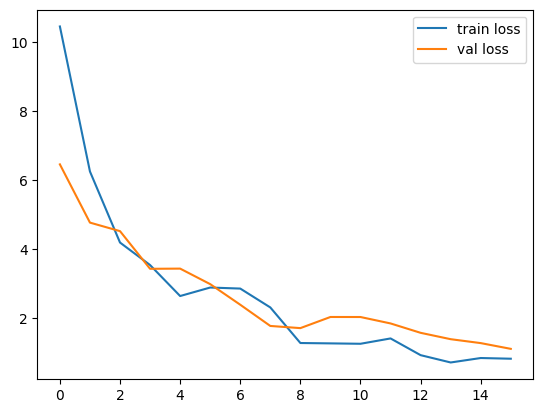

In [97]:
#plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

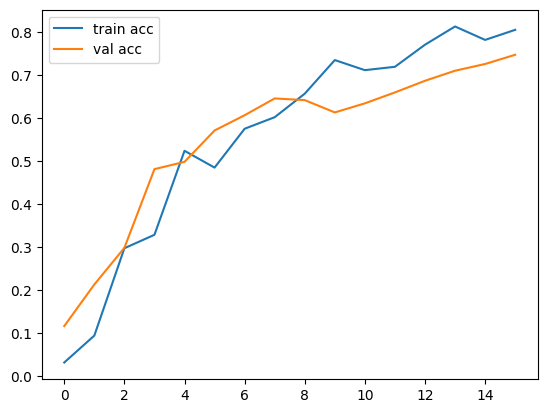

In [98]:
#plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()